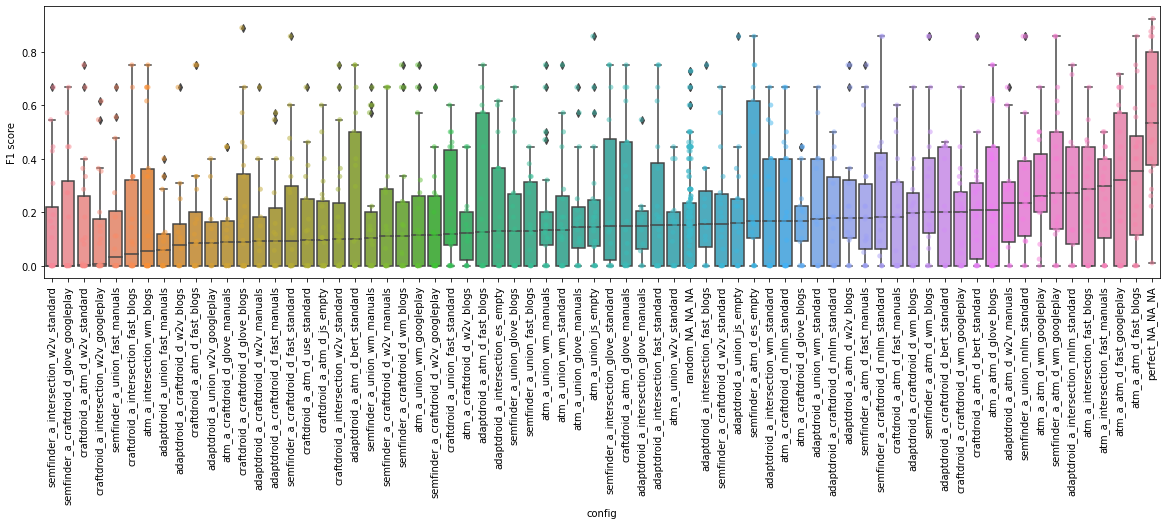

In [67]:
import glob
import os
import sys

from matplotlib import pyplot as plt
import seaborn as sn

sys.path.append("..")
import pandas as pd
from pandas.io.parsers import read_csv

from utils.configuration import Configuration

config = Configuration()


class Analyse:
    def __init__(self, approach, subjects, oracles, oracles_pass=False):
        self.approach = approach
        self.subjects = subjects
        self.oracles = oracles
        self.oracles_pass = oracles_pass
        self.final_result = None

    def run(self):
        results = self.read_results()
        results_joined_sm = self.join_with_mrr(results)
        self.make_bplots(results_joined_sm)
        results_grouped_by_config = results_joined_sm.groupby('config').mean().sort_values(by=['f1_score'],
                                                                                           ascending=False)
        results_converted_config = Analyse.convert_config_names(results_grouped_by_config)
        results_converted_config = self.normalize_top1(results_converted_config)
        save_path = self.get_save_path('full')
        results_converted_config.round(4).to_csv(save_path, index=False)
        self.save_short(results_converted_config)
        self.save_for_plot(results_converted_config)

    def read_results(self):
        desc_map_files = []
        for path in glob.glob('../' + self.get_result_dir() + "/*.csv"):
            csv = read_csv(path, encoding='latin-1')
            csv = self.add_file_name(csv, path)
            desc_map_files.append(csv)
        results = pd.concat(desc_map_files, axis=0, ignore_index=True)
        results = self.filter_results(results)
        results.drop('target_app', inplace=True, axis=1)
        results.drop('src_app', inplace=True, axis=1)
        results.fillna(0, inplace=True)
        results.set_index('config', inplace=True)
        return results

    def join_with_mrr(self, result):
        configs_sm_results = self.get_sm_results()
        return result.join(configs_sm_results).sort_values(by=['f1_score'], ascending=False)

    def get_result_dir(self):
        results_dir = f"data/output/evaluation/{self.approach}/oracles_"
        results_dir += 'included/' if self.oracles else 'excluded/'
        if self.approach == 'atm' and self.oracles:
            results_dir += 'with_oracle_pass' if self.oracles_pass else 'without_oracle_pass'
        return results_dir

    def filter_results(self, results):
        if self.approach == 'craftdroid':
            if self.subjects == 'craftdroid':
                return results[~results['target_app'].str.contains('a6|a7|a8')]
            elif self.subjects == 'atm':
                return results[results['target_app'].str.contains('a6|a7|a8')]
        return results

    def get_sm_results(self):
        path = '../' + config.analyse_dir + f'/latest_{self.subjects}.csv'
        configs_sm = read_csv(path)
        configs_sm['config'] = configs_sm[['word_embedding', 'training_set', 'algorithm', 'descriptors']].agg(
            '_'.join, axis=1)
        configs_sm.drop(
            columns=['descriptors', 'word_embedding', 'training_set', 'algorithm', 'top2', 'top3', 'top4', 'top5',
                     'time', 'zeros'], inplace=True)
        configs_sm.set_index('config', inplace=True)
        return configs_sm

    def add_file_name(self, csv, path):
        file_name = os.path.basename(path).split('.')[0]
        file_name = file_name.split('result_')[1]
        if 'random' in file_name:
            file_name = 'NA_NA_random_NA'
        if self.approach == 'atm' and 'perfect' in file_name and not '3' in file_name:
            return None
        if 'perfect' in file_name:
            file_name = 'NA_NA_perfect_NA'

        csv['config'] = file_name
        return csv

    def get_save_path(self, detail_lvl):
        oracle_status = 'oracle' if self.oracles else 'nooracle'
        oracle_pass = ''
        if self.oracles and self.approach == 'atm':
            oracle_pass = '_pass' if self.oracles_pass else '_passfree'
        options = f'{self.approach}_{self.subjects}_{oracle_status}{oracle_pass}_{detail_lvl}'
        if detail_lvl == 'boxplot':
            save_path = 'config_f1_range/' + f'{options}.pdf'
        else:
            save_path = '../' + config.analyse_dir + f'{detail_lvl}/{options}.csv'
        return save_path

    @staticmethod
    def convert_config_names(df):
        df.reset_index(inplace=True)
        df = df.rename(
            columns={'index': 'config', 'tp': 'TP', 'fp': 'FP', 'tn': 'TN', 'fn': 'FN', 'effort_leveneshtein': 'E.L.',
                     'effort_damerau_levenshtein': 'E.D.L', 'accuracy': 'Accuracy', 'precision': 'Precision',
                     'recall': 'Recall', 'f1_score': 'F1 score', 'top1': 'Top1'})

        df['config'] = df['config'].apply(lambda x: x.replace('edit_distance', 'es'))
        df['config'] = df['config'].apply(lambda x: x.replace('jaccard', 'js'))
        df['Training'] = df['config'].apply(lambda x: x.split('_')[1])
        df['Embedding'] = df['config'].apply(lambda x: x.split('_')[0])
        df['Descriptors'] = df['config'].apply(lambda x: x.split('_')[3])
        df['Algorithm'] = df['config'].apply(lambda x: x.split('_')[2])
        df['Descriptors'] = df['Descriptors'].apply(lambda x: x.replace('craftdroid', 'craftdroid_d'))
        df['Descriptors'] = df['Descriptors'].apply(lambda x: x.replace('atm', 'atm_d'))
        df['Algorithm'] = df['Algorithm'].apply(lambda x: x.replace('atm', 'atm_a'))
        df['Algorithm'] = df['Algorithm'].apply(lambda x: x.replace('craftdroid', 'craftdroid_a'))
        df['Algorithm'] = df['Algorithm'].apply(lambda x: x.replace('custom', 'semfinder_a'))
        df['Algorithm'] = df['Algorithm'].apply(lambda x: x.replace('adaptdroid', 'adaptdroid_a'))
        df['Training'] = df['Training'].apply(lambda x: x.replace('android', 'manuals'))
        df = Analyse.reorder_columns(df)
        return df

    @staticmethod
    def reorder_columns(df):
        df.drop('config', inplace=True, axis=1)
        first_column = df.pop('Algorithm')
        df.insert(0, 'Algorithm', first_column)
        second = df.pop('Descriptors')
        df.insert(1, 'Descriptors', second)
        third = df.pop('Embedding')
        df.insert(2, 'Embedding', third)
        forth = df.pop('Training')
        df.insert(3, 'Training', forth)
        last = df.pop('MRR')
        df.insert(16, 'MRR', last)
        forth = df.pop('reduction_leveneshtein')
        df.insert(10, 'R.L.', forth)
        last = df.pop('reduction_damerau_leveneshtein')
        df.insert(11, 'R.D.L', last)
        df = df.rename(columns={'index': 'config'})
        return df

    def save_short(self, results_converted_config):
        short_columns = ['Algorithm', 'Descriptors', 'Embedding', 'Training', 'E.L.', 'R.L.', 'Accuracy', 'Precision',
                         'Recall', 'F1 score', 'MRR', 'Top1']
        save_path = self.get_save_path('short')
        results_converted_config[short_columns].round(4).to_csv(save_path, index=False)

    def save_for_plot(self, results_converted_config):
        results = results_converted_config.rename(
            columns={'Algorithm': 'algorithm', 'Descriptors': 'descriptors', 'Embedding': 'word_embedding',
                     'Training': 'training_set', 'F1 score': 'value'})
        short_columns = ['algorithm', 'descriptors', 'word_embedding', 'training_set', 'value']
        save_path = self.get_save_path('forplot')
        results[short_columns].to_csv(save_path, index=False)

    def normalize_top1(self, results_converted_config):
        q_num = {'atm': 116, 'all': 337, 'craftdroid': 221}
        results_converted_config['Top1'] = results_converted_config['Top1'].apply(
            lambda x: float(x) / q_num[self.subjects])
        return results_converted_config

    def make_bplots(self, df):
        save_path = self.get_save_path('boxplot')
        data = df.copy()
        data = Analyse.convert_config_names(data)
        data['config'] = data['Algorithm'] + '_' + data['Descriptors'] + '_' +  data['Embedding'] + '_' + data['Training']
        order = data.groupby(by=["config"])["F1 score"].median().sort_values(ascending=True).index
        plt.clf()
        plt.close()
        plt.figure(figsize=(20, 5))
        ax = sn.boxplot(data=data, y='F1 score', x='config', order=order)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        sn.stripplot(data=data, y='F1 score', x='config', jitter=True,
                     dodge=True,
                     marker='o',
                     alpha=0.5, order=order)

        plt.savefig(save_path, bbox_inches='tight')

analyzor = Analyse('atm', 'atm', oracles=True, oracles_pass=False)
analyzor.run()


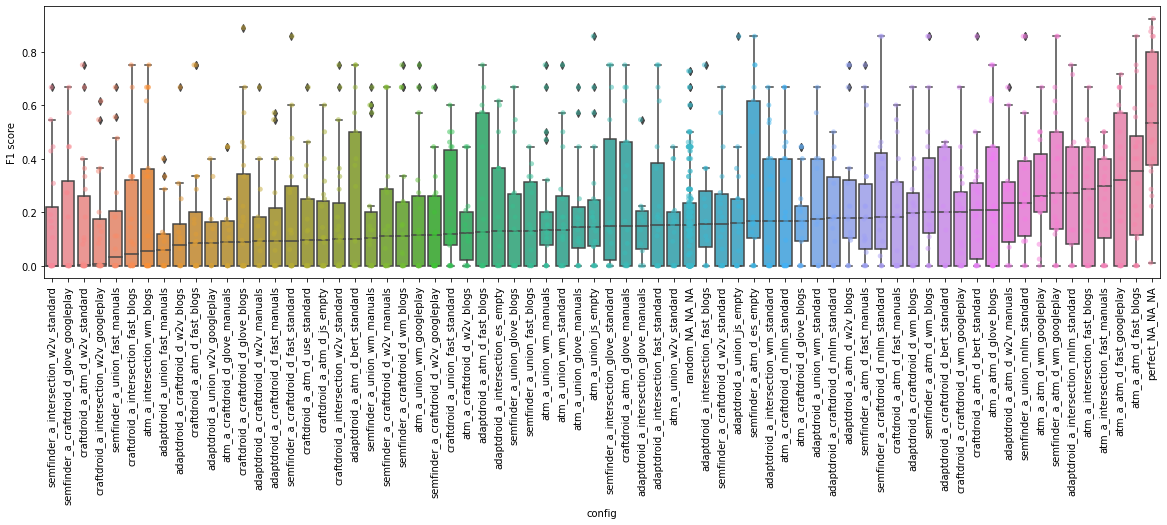

In [68]:
# analyzor = Analyse('craftdroid', 'all', oracles=False)
# analyzor.run()
# analyzor = Analyse('craftdroid', 'craftdroid', oracles=False)
# analyzor.run()
# analyzor = Analyse('craftdroid', 'atm', oracles=False)
# analyzor.run()

analyzor = Analyse('craftdroid', 'all', oracles=True)
analyzor.run()
# analyzor = Analyse('craftdroid', 'craftdroid', oracles=True)
# analyzor.run()
# analyzor = Analyse('craftdroid', 'atm', oracles=True)
# analyzor.run()
#
# analyzor = Analyse('atm', 'atm', oracles=True, oracles_pass=True)
# analyzor.run()
analyzor = Analyse('atm', 'atm', oracles=True, oracles_pass=False)
analyzor.run()
# analyzor = Analyse('atm', 'atm', oracles=False)
# analyzor.run()